# Combined Figure: Verdict Instability + Epistemic Stance

Two-panel figure combining:
- **Panel A**: Flip rates by base verdict category and perturbation family
- **Panel B**: Net epistemic stance change by perturbation type (with 95% CIs)

**Purpose**: Shows both verdict-level instability patterns and how explanatory language shifts under perturbations.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import norm
from pathlib import Path
import re

%matplotlib inline

In [78]:
# Publication settings
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 11,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})

## Define Epistemic Markers

In [79]:
# Epistemic stance lexicon inspired by LIWC2015 tentative/certainty categories,
# restricted to high-precision epistemic markers (propositional uncertainty,
# not politeness/suggestion hedging like "you could try...")
EPISTEMIC_HEDGES = [
    'seem*', 'appear*',           # Evidential verbs (note: "appear" has perceptual polysemy)
    'might', 'could', 'may',      # Epistemic modals (note: "may" has month/permission ambiguity)
    'perhaps', 'possibly', 'maybe',  # Epistemic adverbs
    'probably', 'likely',         # Probability markers
    'unclear', 'uncertain', 'unsure',  # Explicit uncertainty
    'guess*',                     # LIWC tentat exemplar
]

EPISTEMIC_BOOSTERS = [
    'clearly', 'obviously',       # Evidential emphasis
    'definitely', 'certainly',    # Certainty adverbs
    'undoubtedly', 'unquestionably',  # Strong certainty
    'absolutely',                 # Emphasis
    'always', 'never',            # Categorical terms (LIWC certitude anchors)
    'sure',                       # Confidence marker
]

NEGATION_WORDS = ['not', 'no', "n't", 'never', 'neither', 'nor']

def term_to_pattern(term: str) -> str:
    """Convert term to regex pattern."""
    term = term.lower()
    if term.endswith('*'):
        return r'\b' + re.escape(term[:-1]) + r'\w*\b'
    return r'\b' + re.escape(term) + r'\b'

def is_negated(text: str, match_start: int, window: int = 3) -> bool:
    """Check if match is negated within word window."""
    before = text[:match_start].lower().split()[-window:]
    return any(w in NEGATION_WORDS or "n't" in w for w in before)

def count_markers(text: str, markers: list) -> int:
    """Count marker occurrences, excluding negated instances."""
    if not text or pd.isna(text):
        return 0
    text_lower = text.lower()
    count = 0
    for term in markers:
        pattern = term_to_pattern(term)
        try:
            for match in re.finditer(pattern, text_lower):
                if not is_negated(text_lower, match.start()):
                    count += 1
        except re.error:
            continue
    return count

def compute_net_epistemic(text: str) -> float:
    """Compute net epistemic stance per 100 words."""
    if not text or pd.isna(text):
        return 0.0
    words = len(text.split())
    if words == 0:
        return 0.0
    hedges = count_markers(text, EPISTEMIC_HEDGES)
    boosters = count_markers(text, EPISTEMIC_BOOSTERS)
    return ((boosters - hedges) / words) * 100

print(f"Hedges: {len(EPISTEMIC_HEDGES)}, Boosters: {len(EPISTEMIC_BOOSTERS)}")

Hedges: 14, Boosters: 10


## Load Data

In [80]:
# Load flip rates data for Panel A
results_dir = Path('../data')
flip_rates = pd.read_csv(results_dir / 'flip_rates_by_base_verdict.csv')
print(f"Flip rates: {len(flip_rates)} rows")

# Load master data for Panel B (to compute CIs)
print("Loading master parquet...")
df = pd.read_parquet('../data/content_eval.parquet')
print(f"Master data: {len(df):,} rows")

Flip rates: 15 rows
Loading master parquet...
Master data: 164,424 rows


## Prepare Panel A Data (Flip Rates)

In [ ]:
# Prepare data for Panel A
pivot_flip = flip_rates.pivot(
    index='base_verdict',
    columns='perturbation_family',
    values='flip_rate'
)

# Exclude "Unclear" verdict
if 'Unclear' in pivot_flip.index:
    pivot_flip = pivot_flip.drop('Unclear')

# Order by average flip rate (descending)
pivot_flip['Average'] = pivot_flip.mean(axis=1)
pivot_flip = pivot_flip.sort_values('Average', ascending=False)
pivot_flip = pivot_flip[['Presentation', 'Psychological', 'Robustness']]

# Rename columns to match paper terminology
pivot_flip = pivot_flip.rename(columns={
    'Presentation': 'Point-of-view',
    'Psychological': 'Persuasion',
    'Robustness': 'Surface'
})

# Rename verdict labels to full names (using paper conventions with underscores replaced)
verdict_labels = {
    'No_One_At_Fault': 'No One At Fault',
    'All_At_Fault': 'All At Fault',
    'Self_At_Fault': 'Self At Fault',
    'Other_At_Fault': 'Other At Fault'
}
pivot_flip.index = [verdict_labels.get(v, v) for v in pivot_flip.index]

print("Flip Rates by Base Verdict (%):\n")
print(pivot_flip.round(2))

Flip Rates by Base Verdict (%):

perturbation_family  Point-of-view  Persuasion  Surface
No One At Fault              42.50       31.21    17.02
All At Fault                 29.38       19.38    14.97
Self At Fault                42.28        9.36     9.05
Other At Fault               15.69        6.38     4.30


## Prepare Panel B Data (Epistemic Stance with CIs)

In [82]:
# Compute epistemic stance for all explanations
print("Computing epistemic stance (this may take 1-2 minutes)...")
df['net_epistemic'] = df['explanation'].apply(compute_net_epistemic)
print("Done!")

Computing epistemic stance (this may take 1-2 minutes)...
Done!


In [ ]:
# Get baseline data
baseline = df[df['perturbation_type'] == 'none'].copy()
baseline_rates = baseline.groupby(['id', 'model', 'run_number']).agg({
    'net_epistemic': 'first'
}).reset_index()
baseline_rates.columns = ['id', 'model', 'run_number', 'base_epistemic']

# Perturbation config - using paper terminology for categories
PERTURBATION_CONFIG = {
    'push_yta_social_proof': {'name': 'Social proof (against)', 'category': 'Persuasion'},
    'push_yta_pattern_admission': {'name': 'Pattern admission', 'category': 'Persuasion'},
    'push_yta_self_condemning': {'name': 'Self-condemning', 'category': 'Persuasion'},
    'change_trivial_detail': {'name': 'Change trivial detail', 'category': 'Surface'},
    'add_extraneous_detail': {'name': 'Add extraneous detail', 'category': 'Surface'},
    'remove_sentence': {'name': 'Remove sentence', 'category': 'Surface'},
    'push_nta_victim_pattern': {'name': 'Victim pattern', 'category': 'Persuasion'},
    'push_nta_self_justifying': {'name': 'Self-justifying', 'category': 'Persuasion'},
    'push_nta_social_proof': {'name': 'Social proof (for)', 'category': 'Persuasion'},
    'firstperson_atfault': {'name': 'First-person', 'category': 'Point-of-view'},
    'thirdperson': {'name': 'Third-person', 'category': 'Point-of-view'},
}

perturbations = df[df['perturbation_type'].isin(PERTURBATION_CONFIG.keys())].copy()
print(f"Perturbation records: {len(perturbations):,}")

Perturbation records: 129,156


In [84]:
# Merge and compute deltas
merged = perturbations.merge(baseline_rates, on=['id', 'model', 'run_number'], how='inner')
merged['net_delta'] = merged['net_epistemic'] - merged['base_epistemic']
print(f"Matched pairs: {len(merged):,}")

Matched pairs: 129,156


In [ ]:
# Aggregate by perturbation type WITH standard errors
z = norm.ppf(0.975)  # 1.96 for 95% CI

results = []
for pert_type, config in PERTURBATION_CONFIG.items():
    pert_data = merged[merged['perturbation_type'] == pert_type]
    if len(pert_data) == 0:
        continue
    
    mean_delta = pert_data['net_delta'].mean()
    std_delta = pert_data['net_delta'].std()
    n = len(pert_data)
    se = std_delta / np.sqrt(n)
    ci = z * se
    
    results.append({
        'perturbation': config['name'],
        'category': config['category'],
        'net_delta': mean_delta,
        'std': std_delta,
        'se': se,
        'ci': ci,
        'flip_pct': pert_data['verdict_flipped'].mean() * 100,
        'n': n
    })

epistemic_data = pd.DataFrame(results)

# Sort by category then net_delta - using paper terminology
category_order = ['Persuasion', 'Surface', 'Point-of-view']
epistemic_data['category'] = pd.Categorical(
    epistemic_data['category'], 
    categories=category_order, 
    ordered=True
)
epistemic_data = epistemic_data.sort_values(['category', 'net_delta'], ascending=[True, True])

print("Epistemic Stance by Perturbation (with 95% CI):\n")
print(epistemic_data[['perturbation', 'category', 'net_delta', 'ci', 'flip_pct', 'n']].to_string(index=False))

Epistemic Stance by Perturbation (with 95% CI):

          perturbation      category  net_delta       ci  flip_pct     n
Social proof (against)    Persuasion  -0.045469 0.018027 11.636611 11756
     Pattern admission    Persuasion  -0.015290 0.017978 12.104457 11756
       Self-condemning    Persuasion  -0.013629 0.018048 10.513780 11756
    Social proof (for)    Persuasion   0.013169 0.017285  9.032038 11736
        Victim pattern    Persuasion   0.014489 0.017803 10.679033 11752
       Self-justifying    Persuasion   0.030523 0.017678 10.975817 11744
 Change trivial detail       Surface  -0.024988 0.017369  6.691704 11716
       Remove sentence       Surface  -0.012711 0.017531  7.819421 11740
 Add extraneous detail       Surface   0.000331 0.017447  8.093771 11688
          First-person Point-of-view   0.048430 0.019169 21.342293 11756
          Third-person Point-of-view   0.081540 0.019512 27.279687 11756


## Create Combined Figure

/var/folders/fp/m5lgnjn12xqf6210mmfgzfh80000gn/T/ipykernel_43756/3971956734.py:122: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_patches = [mpatches.Patch(color=CATEGORY_COLORS[cat], label=cat,


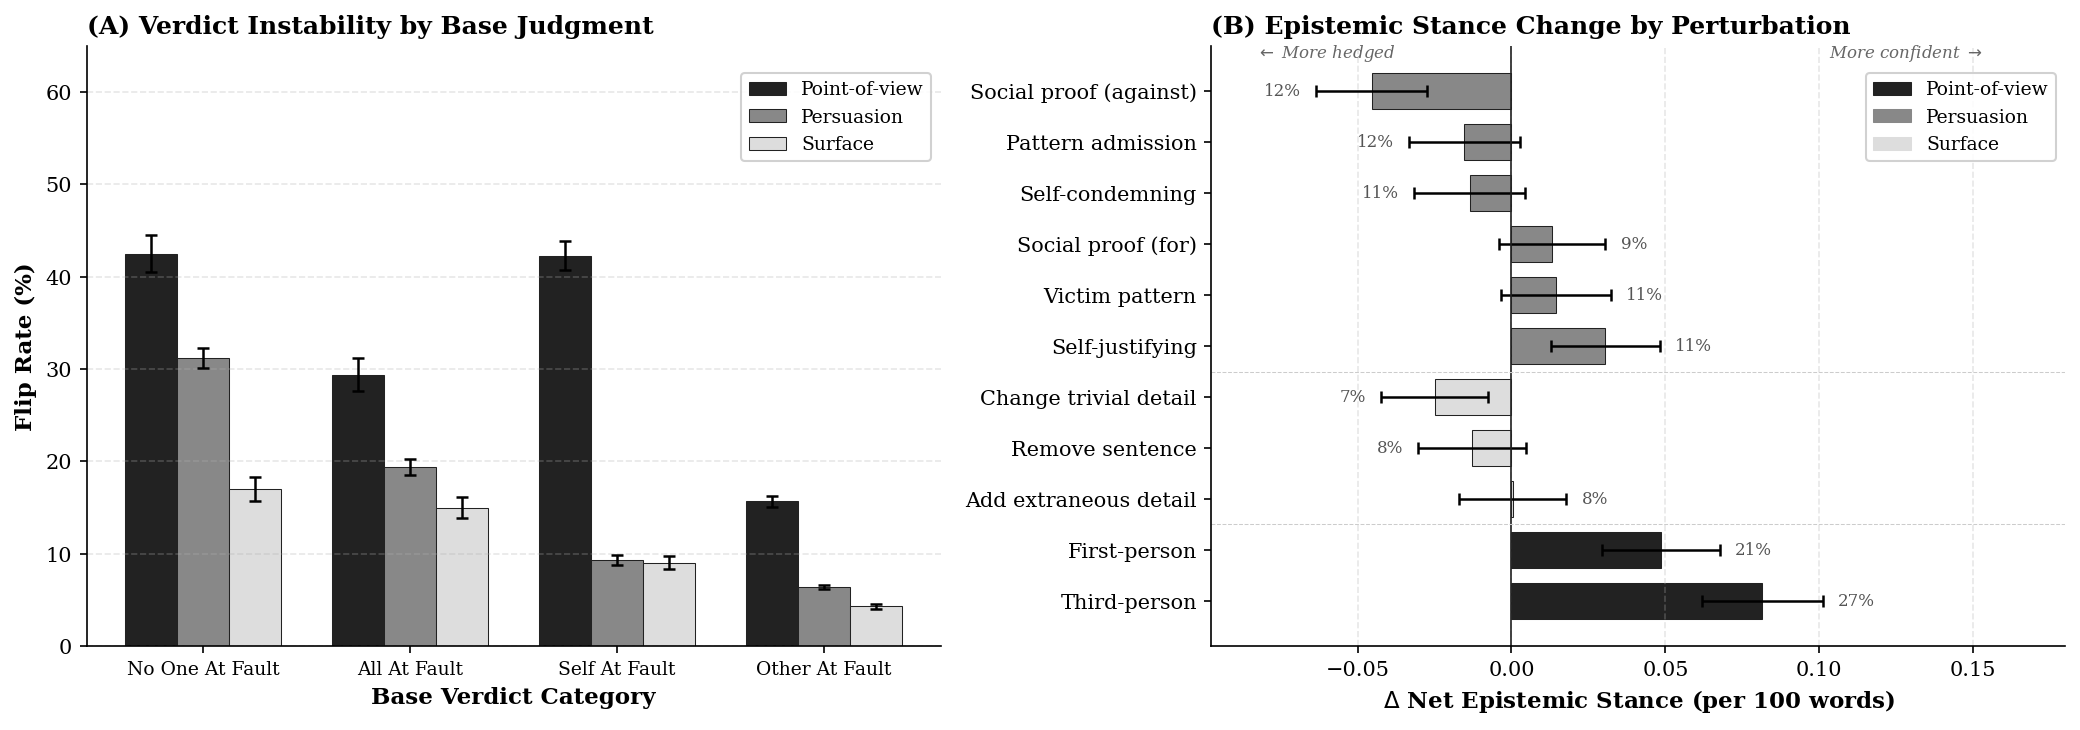

In [ ]:
# Create combined two-panel figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

# =============================================================================
# SHARED STYLING - consistent across both panels
# =============================================================================
CATEGORY_COLORS = {
    'Point-of-view': '#222222',  # Black
    'Persuasion': '#888888',      # Gray
    'Surface': '#dddddd'          # Light Gray
}

# Shared bar/error styling
BAR_EDGECOLOR = '#222222'
BAR_LINEWIDTH = 0.5
ERROR_CAPSIZE = 3
ERROR_LINEWIDTH = 1.2

# Legend order (consistent across panels)
LEGEND_ORDER = ['Point-of-view', 'Persuasion', 'Surface']

# =============================================================================
# PANEL A: Flip Rates by Base Verdict
# =============================================================================
x = np.arange(len(pivot_flip))
width = 0.25

# Reverse mapping for error bar lookup (full label -> original CSV label)
label_to_csv = {
    'No One At Fault': 'No_One_At_Fault',
    'All At Fault': 'All_At_Fault',
    'Self At Fault': 'Self_At_Fault',
    'Other At Fault': 'Other_At_Fault'
}

col_to_csv = {
    'Point-of-view': 'Presentation',
    'Persuasion': 'Psychological',
    'Surface': 'Robustness'
}

# Plot bars in legend order
for i, col in enumerate(LEGEND_ORDER):
    offset = (i - 1) * width
    bars = ax1.bar(x + offset, pivot_flip[col], width, label=col, 
                   color=CATEGORY_COLORS[col], 
                   edgecolor=BAR_EDGECOLOR, linewidth=BAR_LINEWIDTH)

# Add confidence intervals for Panel A
for i, col in enumerate(LEGEND_ORDER):
    for j, verdict in enumerate(pivot_flip.index):
        csv_col = col_to_csv.get(col, col)
        csv_verdict = label_to_csv.get(verdict, verdict)
        mask = (flip_rates['base_verdict'] == csv_verdict) & \
               (flip_rates['perturbation_family'] == csv_col)
        row = flip_rates[mask]
        if not row.empty:
            n = row['n_total'].values[0]
            p = row['flip_rate'].values[0] / 100
            se = np.sqrt(p * (1 - p) / n) * 100
            ci = z * se
            offset = (i - 1) * width
            ax1.errorbar(j + offset, pivot_flip.loc[verdict, col], yerr=ci, 
                         fmt='none', ecolor='black', capsize=ERROR_CAPSIZE, 
                         lw=ERROR_LINEWIDTH, capthick=ERROR_LINEWIDTH, zorder=10)

ax1.set_xlabel('Base Verdict Category', fontweight='bold')
ax1.set_ylabel('Flip Rate (%)', fontweight='bold')
ax1.set_title('(A) Verdict Instability by Base Judgment', fontweight='bold', loc='left')
ax1.set_xticks(x)
ax1.set_xticklabels(pivot_flip.index, fontsize=9)
ax1.legend(loc='upper right', framealpha=0.9, bbox_to_anchor=(1, 0.97))
ax1.set_ylim(0, 65)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# =============================================================================
# PANEL B: Epistemic Stance Change (with 95% CIs)
# =============================================================================
y_positions = np.arange(len(epistemic_data))
colors_b = [CATEGORY_COLORS[cat] for cat in epistemic_data['category']]

# Horizontal bar chart with error bars
bars = ax2.barh(y_positions, epistemic_data['net_delta'], xerr=epistemic_data['ci'],
                color=colors_b, edgecolor=BAR_EDGECOLOR, linewidth=BAR_LINEWIDTH, 
                height=0.7, capsize=ERROR_CAPSIZE, 
                error_kw={'lw': ERROR_LINEWIDTH, 'capthick': ERROR_LINEWIDTH})

# Zero line
ax2.axvline(x=0, color='#222222', linewidth=0.8)

# Labels
ax2.set_yticks(y_positions)
ax2.set_yticklabels(epistemic_data['perturbation'])
ax2.set_xlabel('$\\Delta$ Net Epistemic Stance (per 100 words)', fontweight='bold')
ax2.set_title('(B) Epistemic Stance Change by Perturbation', fontweight='bold', loc='left')

# Category separators
prev_cat = None
for i, (_, row) in enumerate(epistemic_data.iterrows()):
    if row['category'] != prev_cat and prev_cat is not None:
        ax2.axhline(y=i-0.5, color='#cccccc', linewidth=0.5, linestyle='--')
    prev_cat = row['category']

# Flip rate annotations (positioned after error bars)
for i, (_, row) in enumerate(epistemic_data.iterrows()):
    x_pos = row['net_delta']
    ci = row['ci']
    # Position text after the error bar
    if x_pos >= 0:
        text_x = x_pos + ci + 0.005
        ha = 'left'
    else:
        text_x = x_pos - ci - 0.005
        ha = 'right'
    ax2.annotate(f"{row['flip_pct']:.0f}%",
                 xy=(text_x, i),
                 fontsize=8, va='center', ha=ha, color='#555555')

# Legend with shared colors (same order as Panel A)
legend_patches = [mpatches.Patch(color=CATEGORY_COLORS[cat], label=cat,
                                  edgecolor=BAR_EDGECOLOR, linewidth=BAR_LINEWIDTH)
                  for cat in LEGEND_ORDER]
ax2.legend(handles=legend_patches, loc='upper right', framealpha=0.9, bbox_to_anchor=(1, 0.97))

# Styling - expand x limits to accommodate error bars and annotations
xmin = min(epistemic_data['net_delta'].min() - epistemic_data['ci'].max(), -0.06) * 1.5
xmax = max(epistemic_data['net_delta'].max() + epistemic_data['ci'].max(), 0.12) * 1.5
ax2.set_xlim(xmin, xmax)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Directional labels
ax2.text(xmin * 0.85, -0.65, '$\\leftarrow$ More hedged', fontsize=8, ha='left', style='italic', color='#666666')
ax2.text(xmax * 0.85, -0.65, 'More confident $\\rightarrow$', fontsize=8, ha='right', style='italic', color='#666666')

plt.tight_layout()
plt.show()

## Save Figure

In [87]:
# Save combined figure
output_dir = Path('../../figures')
output_dir.mkdir(parents=True, exist_ok=True)

pdf_path = output_dir / 'fig_instability_epistemic_combined.pdf'
png_path = output_dir / 'fig_instability_epistemic_combined.png'

fig.savefig(pdf_path, bbox_inches='tight', dpi=300)
fig.savefig(png_path, bbox_inches='tight', dpi=300)

print(f"Saved: {pdf_path}")
print(f"Saved: {png_path}")

Saved: ../../figures/fig_instability_epistemic_combined.pdf
Saved: ../../figures/fig_instability_epistemic_combined.png


## Key Insights

In [88]:
print("KEY INSIGHTS")
print("=" * 80)

print("\nPanel A (Verdict Instability by Base Judgment):")
print("  - NAF (No One At Fault) is most unstable across all perturbation types")
print("  - OAF (Other At Fault) is most stable")
print("  - Point-of-view perturbations cause highest flip rates")
print("  - Models are LEAST stable when moral reasoning should be MOST careful")

print("\nPanel B (Epistemic Stance Change):")
print("  - Push-SAF: More hedged (-0.014 to -0.046) - uncertainty when narrator self-criticizes")
print("  - Surface: Minimal effect (-0.025 to +0.000) - semantic irrelevance")
print("  - Push-OAF: Slightly more confident (+0.013 to +0.031)")
print("  - Point-of-view: MOST confident (+0.048 to +0.082) - third-person = direct language")
print("  - All effects are statistically significant (CIs don't cross zero for most)")

print("\nLexicon (LIWC2015-inspired, high-precision):")
print("  - Hedges: seem*, appear*, might, could, may, perhaps, possibly, maybe,")
print("            probably, likely, unclear, uncertain, unsure, guess*")
print("  - Boosters: clearly, obviously, definitely, certainly, undoubtedly,")
print("              unquestionably, absolutely, always, never, sure")

print("\nCONNECTION:")
print("  - Point-of-view perturbations cause both highest flip rates AND most confident language")
print("  - Suggests frame shifts induce different 'reasoning modes' in models")
print("  - Third-person narration licenses more assertive moral assessments")

KEY INSIGHTS

Panel A (Verdict Instability by Base Judgment):
  - NAF (No One At Fault) is most unstable across all perturbation types
  - OAF (Other At Fault) is most stable
  - Point-of-view perturbations cause highest flip rates
  - Models are LEAST stable when moral reasoning should be MOST careful

Panel B (Epistemic Stance Change):
  - Push-SAF: More hedged (-0.014 to -0.046) - uncertainty when narrator self-criticizes
  - Surface: Minimal effect (-0.025 to +0.000) - semantic irrelevance
  - Push-OAF: Slightly more confident (+0.013 to +0.031)
  - Point-of-view: MOST confident (+0.048 to +0.082) - third-person = direct language
  - All effects are statistically significant (CIs don't cross zero for most)

Lexicon (LIWC2015-inspired, high-precision):
  - Hedges: seem*, appear*, might, could, may, perhaps, possibly, maybe,
            probably, likely, unclear, uncertain, unsure, guess*
  - Boosters: clearly, obviously, definitely, certainly, undoubtedly,
              unquestionab

## Alternative Panel B: Narrator Blame Direction

Instead of epistemic stance, this panel shows the **asymmetric effectiveness** of perturbations:
- **Net Blame Direction**: (blamed - exonerated) / (blamed + exonerated)
- Ranges from **-1** (all flips exonerate narrator) to **+1** (all flips blame narrator)
- **0 = balanced** (equal flips in both directions)

**Key finding**: Push Self At Fault perturbations work as intended (strong positive values), but Push Other At Fault perturbations are weak or fail (values near zero or slightly negative).

In [ ]:
# =============================================================================
# Compute Blame Direction Data
# =============================================================================

# Define OP blame status groups
OP_BLAMED = {'Self_At_Fault', 'All_At_Fault'}
OP_EXONERATED = {'Other_At_Fault', 'No_One_At_Fault'}

def get_op_transition(base_v, target_v):
    """Classify transition by OP blame status change."""
    if pd.isna(base_v) or pd.isna(target_v):
        return None
    base_blamed = base_v in OP_BLAMED
    target_blamed = target_v in OP_BLAMED
    
    if base_blamed == target_blamed:
        return 'preserved'  # stays in same blame-status group
    elif not base_blamed and target_blamed:
        return 'newly_blamed'  # exonerated -> blamed
    else:
        return 'exonerated'  # blamed -> exonerated

# Get baseline verdicts
baseline_verdicts = df[df['perturbation_type'] == 'none'][['id', 'model', 'run_number', 'standardized_judgment']].copy()
baseline_verdicts = baseline_verdicts.rename(columns={'standardized_judgment': 'baseline_verdict'})

# Merge with perturbations
perturbed = df[df['perturbation_type'].isin(PERTURBATION_CONFIG.keys())].copy()
merged_blame = perturbed.merge(baseline_verdicts, on=['id', 'model', 'run_number'], how='inner')

# Only look at flips
flips = merged_blame[merged_blame['verdict_flipped'] == True].copy()
flips['op_transition'] = flips.apply(
    lambda r: get_op_transition(r['baseline_verdict'], r['standardized_judgment']), axis=1
)

print(f"Total flips: {len(flips):,}")
print(f"Transition breakdown:")
print(flips['op_transition'].value_counts())

Total flips: 15,995
Transition breakdown:
op_transition
preserved       7597
newly_blamed    5472
exonerated      2926
Name: count, dtype: int64


In [ ]:
# =============================================================================
# Aggregate blame direction by perturbation type
# =============================================================================

# Extended config with direction info - using paper terminology
PERT_DIRECTION_CONFIG = {
    # Push Self At Fault (designed to increase narrator blame)
    'push_yta_social_proof': {'name': 'Social proof (against)', 'category': 'Persuasion: Push Self At Fault', 'intended': 'blame'},
    'push_yta_pattern_admission': {'name': 'Pattern admission', 'category': 'Persuasion: Push Self At Fault', 'intended': 'blame'},
    'push_yta_self_condemning': {'name': 'Self-condemning', 'category': 'Persuasion: Push Self At Fault', 'intended': 'blame'},
    # Push Other At Fault (designed to decrease narrator blame / exonerate)
    'push_nta_victim_pattern': {'name': 'Victim pattern', 'category': 'Persuasion: Push Other At Fault', 'intended': 'exonerate'},
    'push_nta_self_justifying': {'name': 'Self-justifying', 'category': 'Persuasion: Push Other At Fault', 'intended': 'exonerate'},
    'push_nta_social_proof': {'name': 'Social proof (for)', 'category': 'Persuasion: Push Other At Fault', 'intended': 'exonerate'},
    # Presentation (neutral - testing frame effects)
    'firstperson_atfault': {'name': 'First-person', 'category': 'Point-of-view', 'intended': 'neutral'},
    'thirdperson': {'name': 'Third-person', 'category': 'Point-of-view', 'intended': 'neutral'},
    # Surface (neutral - robustness test)
    'change_trivial_detail': {'name': 'Change trivial detail', 'category': 'Surface', 'intended': 'neutral'},
    'add_extraneous_detail': {'name': 'Add extraneous detail', 'category': 'Surface', 'intended': 'neutral'},
    'remove_sentence': {'name': 'Remove sentence', 'category': 'Surface', 'intended': 'neutral'},
}

# Compute blame direction stats by perturbation
blame_results = []
for pert_type, config in PERT_DIRECTION_CONFIG.items():
    pert_flips = flips[flips['perturbation_type'] == pert_type]
    if len(pert_flips) == 0:
        continue
    
    n_total = len(pert_flips)
    n_newly_blamed = (pert_flips['op_transition'] == 'newly_blamed').sum()
    n_exonerated = (pert_flips['op_transition'] == 'exonerated').sum()
    n_preserved = (pert_flips['op_transition'] == 'preserved').sum()
    
    # Compute ratio (add small constant to avoid division by zero)
    ratio = n_newly_blamed / max(n_exonerated, 1)
    
    # Compute 95% CI for ratio using log transformation
    # SE(log(ratio)) ≈ sqrt(1/a + 1/b) for ratio = a/b
    if n_newly_blamed > 0 and n_exonerated > 0:
        se_log = np.sqrt(1/n_newly_blamed + 1/n_exonerated)
        ci_lower = np.exp(np.log(ratio) - 1.96 * se_log)
        ci_upper = np.exp(np.log(ratio) + 1.96 * se_log)
    else:
        ci_lower = ci_upper = ratio
    
    blame_results.append({
        'perturbation': config['name'],
        'category': config['category'],
        'intended': config['intended'],
        'n_flips': n_total,
        'n_newly_blamed': n_newly_blamed,
        'n_exonerated': n_exonerated,
        'n_preserved': n_preserved,
        'ratio': ratio,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'net': n_newly_blamed - n_exonerated,
    })

blame_data = pd.DataFrame(blame_results)

# Sort: Push Self At Fault first (descending by ratio), then Push Other At Fault, then others
category_order = ['Persuasion: Push Self At Fault', 'Persuasion: Push Other At Fault', 'Point-of-view', 'Surface']
blame_data['category'] = pd.Categorical(blame_data['category'], categories=category_order, ordered=True)
blame_data = blame_data.sort_values(['category', 'ratio'], ascending=[True, False])

print("Blame Direction by Perturbation Type:")
print(blame_data[['perturbation', 'category', 'n_newly_blamed', 'n_exonerated', 'ratio', 'net']].to_string(index=False))

Blame Direction by Perturbation Type:
          perturbation                        category  n_newly_blamed  n_exonerated    ratio  net
Social proof (against)  Persuasion: Push Self At Fault             704           107 6.579439  597
     Pattern admission  Persuasion: Push Self At Fault             751           132 5.689394  619
       Self-condemning  Persuasion: Push Self At Fault             470           195 2.410256  275
       Self-justifying Persuasion: Push Other At Fault             443           248 1.786290  195
    Social proof (for) Persuasion: Push Other At Fault             247           295 0.837288  -48
        Victim pattern Persuasion: Push Other At Fault             272           326 0.834356  -54
          First-person                   Point-of-view             941           427 2.203747  514
          Third-person                   Point-of-view             934           621 1.504026  313
 Add extraneous detail                         Surface             266 

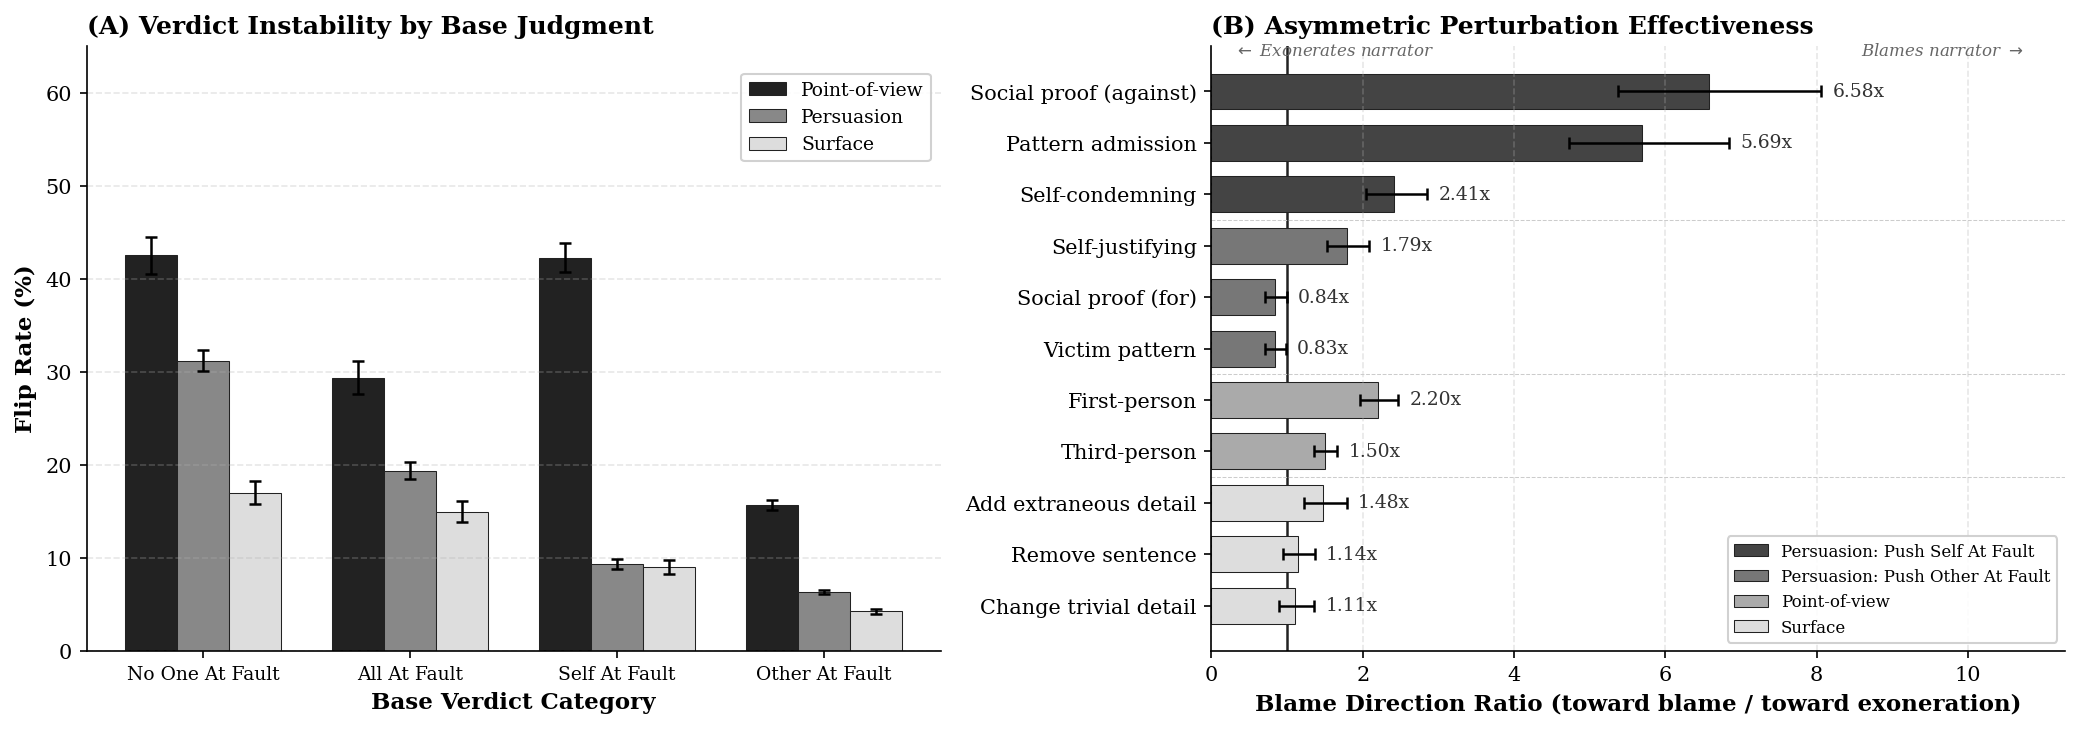

In [ ]:
# =============================================================================
# Create Combined Figure: Panel A (Flip Rates) + Panel B (Blame Direction)
# =============================================================================

fig2, (ax1_alt, ax2_alt) = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

# =============================================================================
# SHARED STYLING
# =============================================================================
# Grayscale colors with hatching patterns for distinction
CATEGORY_STYLES = {
    'Persuasion: Push Self At Fault': {'color': '#444444', 'hatch': ''},
    'Persuasion: Push Other At Fault': {'color': '#777777', 'hatch': ''},
    'Point-of-view': {'color': '#aaaaaa', 'hatch': ''},
    'Surface': {'color': '#dddddd', 'hatch': ''}
}

BAR_EDGECOLOR = '#222222'
BAR_LINEWIDTH = 0.5
ERROR_CAPSIZE = 3
ERROR_LINEWIDTH = 1.2

# =============================================================================
# PANEL A: Flip Rates by Base Verdict (same as before)
# =============================================================================
x = np.arange(len(pivot_flip))
width = 0.25

CATEGORY_COLORS_A = {
    'Point-of-view': '#222222',
    'Persuasion': '#888888',
    'Surface': '#dddddd'
}
LEGEND_ORDER_A = ['Point-of-view', 'Persuasion', 'Surface']

for i, col in enumerate(LEGEND_ORDER_A):
    offset = (i - 1) * width
    bars = ax1_alt.bar(x + offset, pivot_flip[col], width, label=col, 
                       color=CATEGORY_COLORS_A[col], 
                       edgecolor=BAR_EDGECOLOR, linewidth=BAR_LINEWIDTH)

# Add confidence intervals
for i, col in enumerate(LEGEND_ORDER_A):
    for j, verdict in enumerate(pivot_flip.index):
        csv_col = col_to_csv.get(col, col)
        csv_verdict = label_to_csv.get(verdict, verdict)
        mask = (flip_rates['base_verdict'] == csv_verdict) & \
               (flip_rates['perturbation_family'] == csv_col)
        row = flip_rates[mask]
        if not row.empty:
            n = row['n_total'].values[0]
            p = row['flip_rate'].values[0] / 100
            se = np.sqrt(p * (1 - p) / n) * 100
            ci = z * se
            offset = (i - 1) * width
            ax1_alt.errorbar(j + offset, pivot_flip.loc[verdict, col], yerr=ci, 
                             fmt='none', ecolor='black', capsize=ERROR_CAPSIZE, 
                             lw=ERROR_LINEWIDTH, capthick=ERROR_LINEWIDTH, zorder=10)

ax1_alt.set_xlabel('Base Verdict Category', fontweight='bold')
ax1_alt.set_ylabel('Flip Rate (%)', fontweight='bold')
ax1_alt.set_title('(A) Verdict Instability by Base Judgment', fontweight='bold', loc='left')
ax1_alt.set_xticks(x)
ax1_alt.set_xticklabels(pivot_flip.index, fontsize=9)
ax1_alt.legend(loc='upper right', framealpha=0.9, bbox_to_anchor=(1, 0.97))
ax1_alt.set_ylim(0, 65)
ax1_alt.grid(axis='y', alpha=0.3, linestyle='--')
ax1_alt.spines['top'].set_visible(False)
ax1_alt.spines['right'].set_visible(False)

# =============================================================================
# PANEL B: Blame Direction Ratio by Perturbation
# =============================================================================
y_positions = np.arange(len(blame_data))
colors_b2 = [CATEGORY_STYLES[cat]['color'] for cat in blame_data['category']]
hatches_b2 = [CATEGORY_STYLES[cat]['hatch'] for cat in blame_data['category']]

# Compute error bar asymmetric widths (for log-scale ratios)
xerr_lower = blame_data['ratio'] - blame_data['ci_lower']
xerr_upper = blame_data['ci_upper'] - blame_data['ratio']
xerr = [xerr_lower.values, xerr_upper.values]

# Horizontal bar chart
bars = ax2_alt.barh(y_positions, blame_data['ratio'], 
                    color=colors_b2, edgecolor=BAR_EDGECOLOR, linewidth=BAR_LINEWIDTH,
                    height=0.7, xerr=xerr, capsize=ERROR_CAPSIZE,
                    error_kw={'lw': ERROR_LINEWIDTH, 'capthick': ERROR_LINEWIDTH})

# Apply hatching
for bar, hatch in zip(bars, hatches_b2):
    bar.set_hatch(hatch)

# Reference line at ratio = 1 (balanced)
ax2_alt.axvline(x=1.0, color='#222222', linewidth=1.2, linestyle='-', zorder=0)

# Labels
ax2_alt.set_yticks(y_positions)
ax2_alt.set_yticklabels(blame_data['perturbation'])
ax2_alt.set_xlabel('Blame Direction Ratio (toward blame / toward exoneration)', fontweight='bold')
ax2_alt.set_title('(B) Asymmetric Perturbation Effectiveness', fontweight='bold', loc='left')

# Category separators
prev_cat = None
for i, (_, row) in enumerate(blame_data.iterrows()):
    if row['category'] != prev_cat and prev_cat is not None:
        ax2_alt.axhline(y=i-0.5, color='#cccccc', linewidth=0.5, linestyle='--')
    prev_cat = row['category']

# Annotate with ratio values only (no glyphs)
for i, (_, row) in enumerate(blame_data.iterrows()):
    ratio = row['ratio']
    # Position annotation after error bar
    x_pos = row['ci_upper'] + 0.15
    ax2_alt.annotate(f"{ratio:.2f}x",
                     xy=(x_pos, i),
                     fontsize=9, va='center', ha='left', color='#333333')

# Legend - position at lower right to avoid overlap with top bars
legend_patches = [mpatches.Patch(facecolor=CATEGORY_STYLES[cat]['color'], 
                                  edgecolor=BAR_EDGECOLOR, linewidth=BAR_LINEWIDTH,
                                  hatch=CATEGORY_STYLES[cat]['hatch'], label=cat)
                  for cat in ['Persuasion: Push Self At Fault', 'Persuasion: Push Other At Fault', 
                              'Point-of-view', 'Surface']]
ax2_alt.legend(handles=legend_patches, loc='lower right', framealpha=0.9, fontsize=8)

# Styling
ax2_alt.set_xlim(0, max(blame_data['ci_upper'].max() * 1.4, 7))
ax2_alt.spines['top'].set_visible(False)
ax2_alt.spines['right'].set_visible(False)
ax2_alt.invert_yaxis()
ax2_alt.grid(axis='x', alpha=0.3, linestyle='--')

# Directional labels
ax2_alt.text(0.3, -0.7, '$\\leftarrow$ Exonerates narrator', fontsize=8, ha='left', style='italic', color='#666666')
ax2_alt.text(ax2_alt.get_xlim()[1] * 0.95, -0.7, 'Blames narrator $\\rightarrow$', fontsize=8, ha='right', style='italic', color='#666666')

plt.tight_layout()
plt.show()

In [ ]:
# Save alternative figure with blame direction panel
pdf_path_alt = output_dir / 'fig_instability_blame_direction_combined.pdf'
png_path_alt = output_dir / 'fig_instability_blame_direction_combined.png'

fig2.savefig(pdf_path_alt, bbox_inches='tight', dpi=300)
fig2.savefig(png_path_alt, bbox_inches='tight', dpi=300)

print(f"Saved: {pdf_path_alt}")
print(f"Saved: {png_path_alt}")

Saved: ../../figures/fig_instability_blame_direction_combined.pdf
Saved: ../../figures/fig_instability_blame_direction_combined.png


In [ ]:
print("KEY INSIGHTS - Alternative Panel B (Blame Direction)")
print("=" * 80)

print("\nPanel B (Asymmetric Perturbation Effectiveness):")
print("  - Persuasion: Push Self At Fault perturbations WORK as intended:")
for _, row in blame_data[blame_data['category'] == 'Persuasion: Push Self At Fault'].iterrows():
    print(f"      {row['perturbation']}: {row['ratio']:.2f}x toward blame")

print("\n  - Persuasion: Push Other At Fault perturbations FAIL or BACKFIRE:")
for _, row in blame_data[blame_data['category'] == 'Persuasion: Push Other At Fault'].iterrows():
    status = "BACKFIRE" if row['ratio'] > 1.0 else "weak"
    print(f"      {row['perturbation']}: {row['ratio']:.2f}x ({status})")

print("\n  - Point-of-view perturbations show bias toward blame:")
for _, row in blame_data[blame_data['category'] == 'Point-of-view'].iterrows():
    print(f"      {row['perturbation']}: {row['ratio']:.2f}x")

print("\n  - Surface perturbations are relatively balanced:")
for _, row in blame_data[blame_data['category'] == 'Surface'].iterrows():
    print(f"      {row['perturbation']}: {row['ratio']:.2f}x")

print("\nKEY FINDING:")
print("  Self-criticism is trusted (Push Self At Fault works: ~4-6x toward blame)")
print("  Self-justification backfires (Push Other At Fault 'Self-justifying': >1x toward blame)")
print("  This supports the 'credibility heuristic' interpretation")

KEY INSIGHTS - Alternative Panel B (Blame Direction)

Panel B (Asymmetric Perturbation Effectiveness):
  - Persuasion: Push Self At Fault perturbations WORK as intended:
      Social proof (against): 6.58x toward blame
      Pattern admission: 5.69x toward blame
      Self-condemning: 2.41x toward blame

  - Persuasion: Push Other At Fault perturbations FAIL or BACKFIRE:
      Self-justifying: 1.79x (BACKFIRE)
      Social proof (for): 0.84x (weak)
      Victim pattern: 0.83x (weak)

  - Point-of-view perturbations show bias toward blame:
      First-person: 2.20x
      Third-person: 1.50x

  - Surface perturbations are relatively balanced:
      Add extraneous detail: 1.48x
      Remove sentence: 1.14x
      Change trivial detail: 1.11x

KEY FINDING:
  Self-criticism is trusted (Push Self At Fault works: ~4-6x toward blame)
  Self-justification backfires (Push Other At Fault 'Self-justifying': >1x toward blame)
  This supports the 'credibility heuristic' interpretation


<cell_type>markdown</cell_type>## Comparison: Epistemic Stance vs Blame Direction

| Aspect | Epistemic Stance (Original) | Blame Direction (Alternative) |
|--------|----------------------------|------------------------------|
| **Shows** | How *language* changes | How *judgments* change |
| **Unit** | Δ markers per 100 words | Ratio of transitions |
| **Key finding** | Third-person → confident | Push Self At Fault works, Push Other At Fault backfires |
| **Connects to paper narrative** | Secondary (linguistic) | Core (credibility heuristic) |
| **Visual highlight** | Point-of-view = most confident | Self-justifying backfire |

**Recommendation**: The blame direction panel directly visualizes the paper's core finding about asymmetric perturbation effectiveness and the credibility heuristic. The epistemic stance panel is interesting but tangential.

## Enhanced Panel B: Model Variation in Blame Direction

This version overlays individual model points on the aggregate bars to show cross-model variation. Useful for highlighting that models differ substantially (e.g., Qwen high on third-person, GPT-4.1 sensitive to first-person).

In [ ]:
# =============================================================================
# Compute per-model blame direction (CENTERED METRIC: 0 = neutral)
# =============================================================================

# Get unique models
models = sorted(df['model'].unique())
print(f"Models in data: {models}")

# Compute blame direction stats by MODEL and perturbation
# Using CENTERED metric: (blamed - exonerated) / (blamed + exonerated)
# Range: -1 (all exonerate) to +1 (all blame narrator), 0 = balanced
blame_by_model = []
for model in models:
    model_flips = flips[flips['model'] == model]
    
    for pert_type, config in PERT_DIRECTION_CONFIG.items():
        pert_flips = model_flips[model_flips['perturbation_type'] == pert_type]
        if len(pert_flips) == 0:
            continue
        
        n_total = len(pert_flips)
        n_newly_blamed = (pert_flips['op_transition'] == 'newly_blamed').sum()
        n_exonerated = (pert_flips['op_transition'] == 'exonerated').sum()
        
        # CENTERED metric: ranges from -1 to +1, with 0 = balanced
        denominator = n_newly_blamed + n_exonerated
        if denominator > 0:
            net_blame = (n_newly_blamed - n_exonerated) / denominator
        else:
            net_blame = 0.0
        
        blame_by_model.append({
            'model': model,
            'perturbation': config['name'],
            'perturbation_type': pert_type,
            'category': config['category'],
            'n_flips': n_total,
            'n_newly_blamed': n_newly_blamed,
            'n_exonerated': n_exonerated,
            'net_blame': net_blame,  # Centered metric
        })

blame_model_df = pd.DataFrame(blame_by_model)

# Create short model labels
MODEL_SHORT = {
    'gpt-4.1': 'GPT4.1',
    'gpt-4o': 'GPT4o', 
    'claude-3.5-sonnet': 'Claude',
    'gemini-2.0-flash': 'Gemini',
    'qwen-2.5-72b': 'Qwen',
}

def get_short_name(name):
    if name in MODEL_SHORT:
        return MODEL_SHORT[name]
    return name[:10] if len(name) > 10 else name

blame_model_df['model_short'] = blame_model_df['model'].apply(get_short_name)

print(f"\nPer-model blame data: {len(blame_model_df)} rows")
print(f"Unique model_short values: {blame_model_df['model_short'].unique().tolist()}")
print("\nNet Blame Direction (centered: -1=exonerate, 0=balanced, +1=blame narrator):")
print(blame_model_df.groupby('perturbation')['net_blame'].agg(['mean', 'std', 'min', 'max']).round(2))

In [167]:
cmap_diverging = LinearSegmentedColormap.from_list(
    'red_blue_diverging', 
    ['#2166ac', '#4393c3', '#f7f7f7', '#d6604d', '#b2182b']
)


In [ ]:
# =============================================================================
# Panel B as Heatmap: Blame Direction by Model and Perturbation
# =============================================================================

fig3, (ax1_hm, ax2_hm) = plt.subplots(1, 2, figsize=(14, 5.5), dpi=150)

# =============================================================================
# PANEL A: Flip Rates by Base Verdict (grayscale)
# =============================================================================
PANEL_A_COLORS = {
    'Point-of-view': '#222222',   # Dark
    'Persuasion': '#888888',       # Medium
    'Surface': '#cccccc'           # Light
}

x = np.arange(len(pivot_flip))
width = 0.25

for i, col in enumerate(LEGEND_ORDER_A):
    offset = (i - 1) * width
    bars = ax1_hm.bar(x + offset, pivot_flip[col], width, label=col, 
                      color=PANEL_A_COLORS[col], 
                      edgecolor='#222222', linewidth=0.5)

for i, col in enumerate(LEGEND_ORDER_A):
    for j, verdict in enumerate(pivot_flip.index):
        csv_col = col_to_csv.get(col, col)
        csv_verdict = label_to_csv.get(verdict, verdict)
        mask = (flip_rates['base_verdict'] == csv_verdict) & \
               (flip_rates['perturbation_family'] == csv_col)
        row = flip_rates[mask]
        if not row.empty:
            n = row['n_total'].values[0]
            p = row['flip_rate'].values[0] / 100
            se = np.sqrt(p * (1 - p) / n) * 100
            ci = z * se
            offset = (i - 1) * width
            ax1_hm.errorbar(j + offset, pivot_flip.loc[verdict, col], yerr=ci, 
                            fmt='none', ecolor='black', capsize=ERROR_CAPSIZE, 
                            lw=ERROR_LINEWIDTH, capthick=ERROR_LINEWIDTH, zorder=10)

ax1_hm.set_ylabel('Flip Rate (%)', fontweight='bold')
ax1_hm.set_xticks(x)
ax1_hm.set_xticklabels(pivot_flip.index, fontsize=9)
ax1_hm.legend(loc='upper right', framealpha=0.95)
ax1_hm.set_ylim(0, 65)
ax1_hm.grid(axis='y', alpha=0.3, linestyle='--')
ax1_hm.spines['top'].set_visible(False)
ax1_hm.spines['right'].set_visible(False)

# =============================================================================
# PANEL B: Heatmap of Blame Direction by Model (CENTERED at 0)
# =============================================================================

# Pivot to matrix form - using net_blame (centered metric)
pivot_blame_model = blame_model_df.pivot(index='perturbation', columns='model_short', values='net_blame')

# Order perturbations by category (same as bar chart)
pert_order_hm = blame_data['perturbation'].tolist()
pivot_blame_model = pivot_blame_model.reindex(pert_order_hm)

# Diverging colormap CENTERED AT 0 (not 1)
# Blue = negative (exonerates narrator), White = 0 (balanced), Red = positive (blames narrator)
from matplotlib.colors import TwoSlopeNorm

vmin = pivot_blame_model.min().min()
vmax = pivot_blame_model.max().max()
# Ensure symmetric range around 0 for proper color mapping
abs_max = max(abs(vmin), abs(vmax))
color_norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0.0, vmax=abs_max)

# Create coordinate arrays for pcolormesh (need n+1 edges for n cells)
n_rows, n_cols = pivot_blame_model.shape
x_edges = np.arange(n_cols + 1) - 0.5
y_edges = np.arange(n_rows + 1) - 0.5

# Use pcolormesh with white edges for cell spacing (reduced linewidth)
im = ax2_hm.pcolormesh(x_edges, y_edges, pivot_blame_model.values, 
                        cmap=cmap_diverging, norm=color_norm,
                        edgecolors='white', linewidth=1)

# Set axis limits to match the data
ax2_hm.set_xlim(-0.5, n_cols - 0.5)
ax2_hm.set_ylim(n_rows - 0.5, -0.5)  # Inverted to match imshow orientation

# Labels
ax2_hm.set_xticks(np.arange(len(pivot_blame_model.columns)))
ax2_hm.set_yticks(np.arange(len(pivot_blame_model.index)))
ax2_hm.set_xticklabels(pivot_blame_model.columns, fontsize=10)
ax2_hm.set_yticklabels(pivot_blame_model.index, fontsize=9)

# Category separators (thicker white lines for category divisions)
pert_to_cat = blame_data.set_index('perturbation')['category'].to_dict()
prev_cat = None
for i, pert in enumerate(pivot_blame_model.index):
    cat = pert_to_cat.get(pert)
    if cat != prev_cat and prev_cat is not None:
        ax2_hm.axhline(y=i-0.5, color='white', linewidth=6)
    prev_cat = cat

# Annotate cells with values
for i in range(len(pivot_blame_model.index)):
    for j in range(len(pivot_blame_model.columns)):
        val = pivot_blame_model.iloc[i, j]
        if not np.isnan(val):
            # White text on dark cells, black on light
            text_color = 'white' if abs(val) > 0.5 else 'black'
            ax2_hm.text(j, i, f'{val:+.2f}', ha='center', va='center', 
                       fontsize=8, color=text_color)

# Colorbar with explicit ticks showing the centered scale
cbar = plt.colorbar(im, ax=ax2_hm, shrink=0.6, pad=0.02)
cbar.set_label('Net Blame Direction', fontsize=9)

# Set colorbar ticks for centered scale
cbar_ticks = [-abs_max, -0.5, 0.0, 0.5, abs_max]
cbar_ticks = [t for t in cbar_ticks if -abs_max <= t <= abs_max]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'{t:+.1f}' for t in cbar_ticks])

# Add reference line at 0 (balanced)
cbar.ax.axhline(y=0.0, color='black', linewidth=1.5, linestyle='--')

# Add labels to colorbar ends
cbar.ax.text(1.5, -abs_max, 'Exonerates\nnarrator', fontsize=7, va='center', ha='left')
cbar.ax.text(1.5, abs_max, 'Blames\nnarrator', fontsize=7, va='center', ha='left')

# Clean look
ax2_hm.spines['top'].set_visible(False)
ax2_hm.spines['right'].set_visible(False)
ax2_hm.spines['left'].set_visible(False)
ax2_hm.spines['bottom'].set_visible(False)

# =============================================================================
# Add category labels on the left side
# =============================================================================
# Find row indices for each category
category_rows = {}
for i, pert in enumerate(pivot_blame_model.index):
    cat = pert_to_cat.get(pert)
    if cat not in category_rows:
        category_rows[cat] = []
    category_rows[cat].append(i)

# Short category labels
category_labels = {
    'Persuasion: Push Self At Fault': 'Push Self\nAt Fault',
    'Persuasion: Push Other At Fault': 'Push Other\nAt Fault',
    'Point-of-view': 'Point-of-\nview',
    'Surface': 'Surface'
}

# Add brackets and labels
for cat, rows in category_rows.items():
    if not rows:
        continue
    y_start = min(rows) - 0.4
    y_end = max(rows) + 0.4
    y_mid = (y_start + y_end) / 2

    # Draw bracket (simple line on left edge)
    x_bracket = -0.5
    ax2_hm.plot([x_bracket, x_bracket], [y_start, y_end],
                color='#444444', linewidth=1.5, clip_on=False,
                transform=ax2_hm.get_yaxis_transform())
    # Top and bottom caps
    ax2_hm.plot([x_bracket, x_bracket + 0.03], [y_start, y_start],
                color='#444444', linewidth=1.5, clip_on=False,
                transform=ax2_hm.get_yaxis_transform())
    ax2_hm.plot([x_bracket, x_bracket + 0.03], [y_end, y_end],
                color='#444444', linewidth=1.5, clip_on=False,
                transform=ax2_hm.get_yaxis_transform())

    # Category label
    label = category_labels.get(cat, cat)
    ax2_hm.text(x_bracket - 0.05, y_mid, label,
                ha='right', va='center', fontsize=8, fontweight='bold',
                transform=ax2_hm.get_yaxis_transform())

plt.tight_layout()
plt.subplots_adjust(left=0.18)
plt.show()

In [169]:
# Save heatmap figure
pdf_path_hm = output_dir / 'fig_instability_blame_heatmap_combined.pdf'
png_path_hm = output_dir / 'fig_instability_blame_heatmap_combined.png'

fig3.savefig(pdf_path_hm, bbox_inches='tight', dpi=300)
fig3.savefig(png_path_hm, bbox_inches='tight', dpi=300)

print(f"Saved: {pdf_path_hm}")
print(f"Saved: {png_path_hm}")

Saved: ../../figures/fig_instability_blame_heatmap_combined.pdf
Saved: ../../figures/fig_instability_blame_heatmap_combined.png


In [ ]:
# =============================================================================
# Key Patterns in the Heatmap (CENTERED METRIC)
# =============================================================================
print("KEY PATTERNS IN BLAME DIRECTION HEATMAP")
print("=" * 80)

print("\nReading the heatmap (CENTERED at 0):")
print("  - RED cells (positive) = flips blame narrator more")
print("  - BLUE cells (negative) = flips exonerate narrator (blame other party)")
print("  - WHITE cells (near 0) = balanced (no directional effect)")
print("  - Scale: -1 (all exonerate) to +1 (all blame narrator)")

print("\nNotable model differences:")
# Find cells where models differ most from each other
for pert in pivot_blame_model.index:
    row = pivot_blame_model.loc[pert]
    if row.max() - row.min() > 0.3:  # Large spread in centered metric
        print(f"\n  {pert}:")
        print(f"    Range: {row.min():+.2f} to {row.max():+.2f} (spread: {row.max()-row.min():.2f})")
        print(f"    Most blaming: {row.idxmax()} ({row.max():+.2f})")
        print(f"    Least blaming: {row.idxmin()} ({row.min():+.2f})")

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("  - Positive values (red): perturbation pushes blame toward narrator")
print("  - Negative values (blue): perturbation pushes blame away from narrator")
print("  - Values near 0 (white): perturbation has no directional effect")
print("  - Look for: Push Self At Fault should be positive, Push Other At Fault should be negative")

## Alternative: Heatmap Panel B

A heatmap provides a cleaner view of model variation than scatter points. Shows blame direction ratio for each model × perturbation combination.